# Sprint 3: Phân loại trình độ văn bản tiếng Anh với Word2Vec, XGBoost và SHAP

Notebook này thực hiện một quy trình Machine Learning hoàn chỉnh:
1.  **Tải dữ liệu** đã được tiền xử lý từ Sprint trước.
2.  **Huấn luyện Word2Vec** để tạo ra các vector đặc trưng mới cho văn bản.
3.  **Huấn luyện và so sánh** nhiều mô hình phân loại (Logistic Regression, XGBoost, Random Forest) trên cả hai bộ đặc trưng (TF-IDF và Word2Vec).
4.  **Tinh chỉnh siêu tham số** cho mô hình tốt nhất bằng `GridSearchCV`.
5.  **Đánh giá cuối cùng** trên tập dữ liệu kiểm thử (test set).
6.  **Giải thích kết quả** của mô hình bằng thư viện `SHAP`.

## Cài đặt và Import các thư viện cần thiết

In [1]:
%pip install pandas numpy scipy gensim nltk scikit-learn xgboost shap matplotlib
# Dòng trên để cài đặt thư viện nếu cần. Bỏ comment và chạy nếu bạn chưa cài.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import pickle
import time
import joblib
import nltk
import matplotlib.pyplot as plt

# Tiền xử lý & Vector hóa
from scipy.sparse import load_npz, vstack
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# Mô hình
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Đánh giá & Tinh chỉnh
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Giải thích mô hình
import shap

# Đảm bảo bạn đã tải NLTK tokenizer
# nltk.download('punkt', quiet=True)

c:\Users\ADMIN\miniconda3\envs\readee_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BƯỚC 1: TẢI DỮ LIỆU TỪ SPRINT 2

In [3]:
print("Đang tải dữ liệu đã xử lý từ /dataframes/...")

# Tải ma trận TF-IDF (vẫn cần để so sánh)
X_train_tfidf = load_npz('dataframes/X_train_tfidf.npz')
X_val_tfidf = load_npz('dataframes/X_val_tfidf.npz')
X_test_tfidf = load_npz('dataframes/X_test_tfidf.npz')

# Tải nhãn
y_train = pd.read_csv('dataframes/y_train.csv')['label']
y_val = pd.read_csv('dataframes/y_val.csv')['label']
y_test = pd.read_csv('dataframes/y_test.csv')['label']

# Tải văn bản thô (raw text) để huấn luyện Word2Vec
print("Đang tải văn bản thô (train_data.csv, val_data.csv, test_data.csv)...")
df_train = pd.read_csv('dataframes/train_data.csv')
df_val = pd.read_csv('dataframes/val_data.csv')
df_test = pd.read_csv('dataframes/test_data.csv')

# Lấy cột văn bản đã làm sạch và đảm bảo không có giá trị NaN
corpus_train = df_train['text'].dropna()
corpus_val = df_val['text'].dropna()
corpus_test = df_test['text'].dropna()

print("Tải dữ liệu hoàn tất.")

Đang tải dữ liệu đã xử lý từ /dataframes/...
Đang tải văn bản thô (train_data.csv, val_data.csv, test_data.csv)...
Tải dữ liệu hoàn tất.


### Mã hóa nhãn (Label Encoding)

In [4]:
print("Đang mã hóa nhãn (A1->0, A2->1...)...")
le = LabelEncoder()

# Fit trên y_train và transform
y_train_encoded = le.fit_transform(y_train)

# Chỉ transform y_val và y_test
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Lấy tên các nhãn gốc để dùng trong báo cáo
class_names = le.classes_
print(f"Đã mã hóa nhãn: {class_names} -> {le.transform(class_names)}")

print("\nĐang tính toán trọng số (sample_weight) cho mô hình...")
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_encoded # y_train đã được mã hóa
)
print("Tính toán trọng số hoàn tất.")

Đang mã hóa nhãn (A1->0, A2->1...)...
Đã mã hóa nhãn: ['A1' 'A2' 'B1' 'B2'] -> [0 1 2 3]

Đang tính toán trọng số (sample_weight) cho mô hình...
Tính toán trọng số hoàn tất.


## BƯỚC 2: HUẤN LUYỆN WORD2VEC & TẠO FEATURE TRUNG BÌNH

In [5]:
print("--- Đang tạo features bằng Word2Vec ---")

# 1. Chuẩn bị dữ liệu: Word2Vec cần đầu vào là một list các list token (câu).
print("Đang token hóa (phân tách từ) văn bản huấn luyện...")
tokenized_corpus = [word_tokenize(doc) for doc in corpus_train]

# 2. Huấn luyện mô hình Word2Vec
W2V_SIZE = 300
W2V_WINDOW = 5
W2V_MIN_COUNT = 5

print(f"Đang huấn luyện mô hình Word2Vec (size={W2V_SIZE})...")
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=4
)
print("Huấn luyện Word2Vec hoàn tất.")

# Lấy ra bộ từ vựng mà Word2Vec đã học
w2v_vocab = set(w2v_model.wv.index_to_key)
print(f"Kích thước từ vựng Word2Vec: {len(w2v_vocab)} từ")

--- Đang tạo features bằng Word2Vec ---
Đang token hóa (phân tách từ) văn bản huấn luyện...
Đang huấn luyện mô hình Word2Vec (size=300)...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Huấn luyện Word2Vec hoàn tất.
Kích thước từ vựng Word2Vec: 59512 từ


### Tạo ma trận đặc trưng từ Word2Vec (Vector Averaging)

In [6]:
def get_document_vector(doc, model, num_features):
    """
    Tính vector trung bình cho một văn bản (doc).
    """
    tokens = word_tokenize(doc)
    
    # Lọc ra các từ có trong từ vựng của Word2Vec
    valid_tokens = [word for word in tokens if word in w2v_vocab]
    
    if not valid_tokens:
        # Nếu không có từ nào trong từ vựng, trả về vector 0
        return np.zeros(num_features)
    
    # Lấy vector cho từng từ và tính trung bình
    doc_vector = np.mean([model.wv[word] for word in valid_tokens], axis=0)
    return doc_vector

# Áp dụng hàm cho các tập Train, Val, Test
print("Đang tạo ma trận vector trung bình cho Train/Val/Test...")

X_train_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_train])
X_val_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_val])
X_test_w2v = np.array([get_document_vector(doc, w2v_model, W2V_SIZE) for doc in corpus_test])

print("Tạo ma trận Word2Vec hoàn tất.")
print(f"Kích thước X_train (TF-IDF): {X_train_tfidf.shape}")
print(f"Kích thước X_train (Word2Vec): {X_train_w2v.shape}")


Đang tạo ma trận vector trung bình cho Train/Val/Test...
Tạo ma trận Word2Vec hoàn tất.
Kích thước X_train (TF-IDF): (1260, 5000)
Kích thước X_train (Word2Vec): (1260, 300)


## BƯỚC 3: HUẤN LUYỆN LOGISTIC REGRESSION (VỚI WORD2VEC)

--- Đang huấn luyện Logistic Regression với Word2Vec (So sánh) ---
Đánh giá Logistic Regression (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.93      0.85      0.89       100
          A2       0.57      0.57      0.57        30
          B1       0.46      0.57      0.51        21
          B2       0.67      0.76      0.71        29

    accuracy                           0.76       180
   macro avg       0.66      0.69      0.67       180
weighted avg       0.77      0.76      0.76       180


Đang vẽ Confusion Matrix cho Logistic Regression (Word2Vec)...


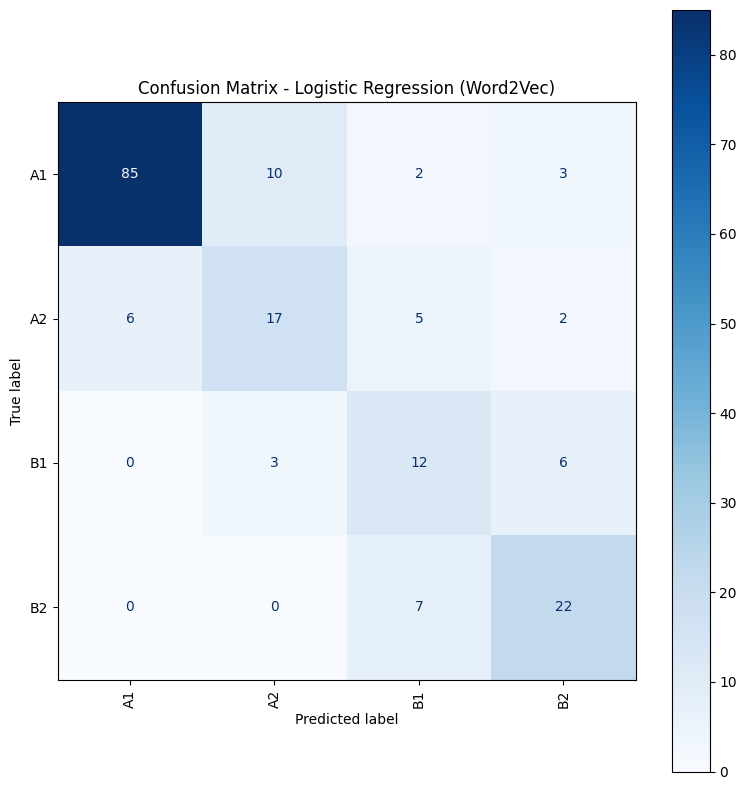

In [ ]:
print("--- Đang huấn luyện Logistic Regression với Word2Vec (So sánh) ---")

model_lr_w2v = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
model_lr_w2v.fit(X_train_w2v, y_train_encoded)

print("Đánh giá Logistic Regression (Word2Vec) trên tập Validation:")
y_pred_val_w2v = model_lr_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_w2v, target_names=class_names))   

print("\nĐang vẽ Confusion Matrix cho Logistic Regression (Word2Vec)...")

# 1. Tính toán ma trận
cm = confusion_matrix(y_val_encoded, y_pred_val_w2v, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression (Word2Vec)")
plt.tight_layout()
plt.show()

## BƯỚC 4: HUẤN LUYỆN XGBOOST (VỚI WORD2VEC)

--- Đang huấn luyện XGBoost với Word2Vec ---
Đang huấn luyện XGBoost (Word2Vec)... (có thể mất vài phút)
Huấn luyện hoàn tất sau 8.15 giây.

Đánh giá XGBoost (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.89      0.96      0.92       100
          A2       0.75      0.60      0.67        30
          B1       0.52      0.52      0.52        21
          B2       0.70      0.66      0.68        29

    accuracy                           0.80       180
   macro avg       0.72      0.68      0.70       180
weighted avg       0.79      0.80      0.79       180


Đang vẽ Confusion Matrix cho XGBoost (Word2Vec)...


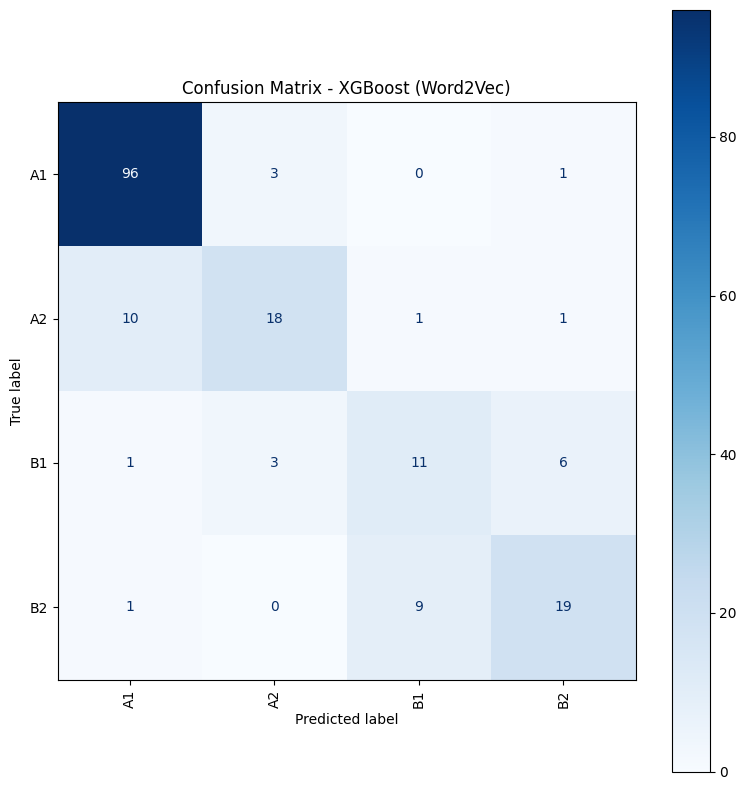

In [8]:
print("--- Đang huấn luyện XGBoost với Word2Vec ---")

model_xgb_w2v = XGBClassifier(
    random_state=42,
    n_estimators=200,      # Số lượng cây
    max_depth=5,           # Độ sâu tối đa của cây
    learning_rate=0.1,     # Tốc độ học
    objective='multi:softmax', # Cho bài toán đa lớp
    num_class=len(class_names), # Số lượng lớp
    n_jobs=-1              # Sử dụng tất cả các CPU
)

print("Đang huấn luyện XGBoost (Word2Vec)... (có thể mất vài phút)")
start_time = time.time()
model_xgb_w2v.fit(X_train_w2v, y_train_encoded,sample_weight=sample_weights)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá XGBoost (Word2Vec) trên tập Validation:")
y_pred_val_xgb = model_xgb_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_xgb, target_names=class_names))

print("\nĐang vẽ Confusion Matrix cho XGBoost (Word2Vec)...")

# 1. Tính toán ma trận
cm_xgb = confusion_matrix(y_val_encoded, y_pred_val_xgb, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - XGBoost (Word2Vec)")
plt.tight_layout()
plt.show()

## BƯỚC 5: HUẤN LUYỆN XGBOOST (VỚI TF-IDF)

--- Đang huấn luyện XGBoost với TF-IDF ---
Đang huấn luyện XGBoost (TF-IDF)...
Huấn luyện hoàn tất sau 42.95 giây.

Đánh giá XGBoost (TF-IDF) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.87      0.96      0.91       100
          A2       0.59      0.43      0.50        30
          B1       0.42      0.38      0.40        21
          B2       0.66      0.66      0.66        29

    accuracy                           0.76       180
   macro avg       0.63      0.61      0.62       180
weighted avg       0.74      0.76      0.74       180


Đang vẽ Confusion Matrix cho XGBoost (TF-IDF)...


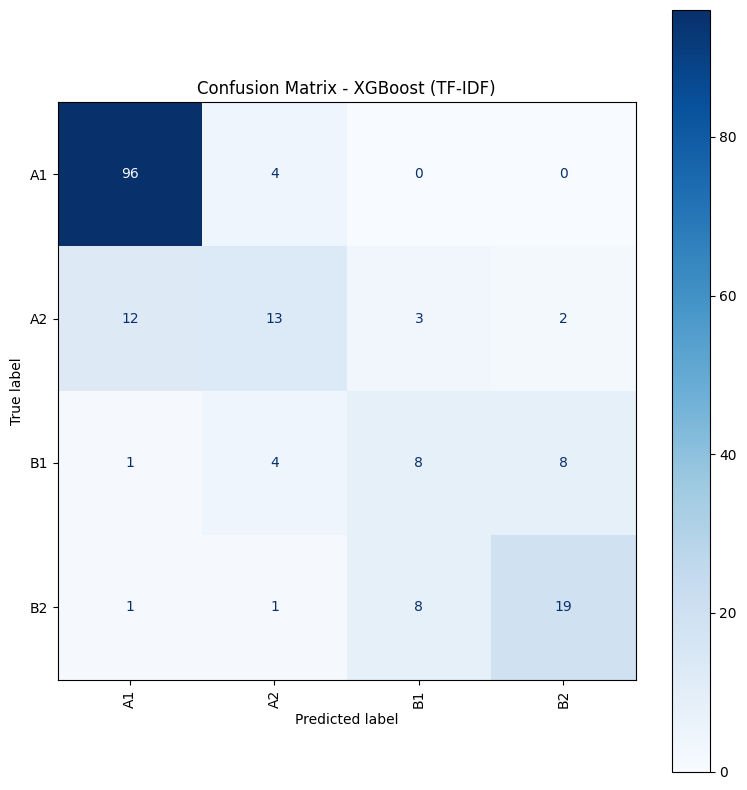

In [9]:
print("--- Đang huấn luyện XGBoost với TF-IDF ---")

model_xgb_tfidf = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(class_names),
    n_jobs=-1
)

print("Đang huấn luyện XGBoost (TF-IDF)...")
start_time = time.time()
model_xgb_tfidf.fit(X_train_tfidf, y_train_encoded, sample_weight=sample_weights)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá XGBoost (TF-IDF) trên tập Validation:")
y_pred_val_xgb_tfidf = model_xgb_tfidf.predict(X_val_tfidf)
print(classification_report(y_val_encoded, y_pred_val_xgb_tfidf, target_names=class_names))

print("\nĐang vẽ Confusion Matrix cho XGBoost (TF-IDF)...")

# 1. Tính toán ma trận
cm_xgb_tfidf = confusion_matrix(y_val_encoded, y_pred_val_xgb_tfidf, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp_xgb_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_tfidf, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp_xgb_tfidf.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - XGBoost (TF-IDF)")
plt.tight_layout()
plt.show()

## BƯỚC 6: HUẤN LUYỆN RANDOM FOREST (VỚI WORD2VEC & TF-IDF)

--- Đang huấn luyện Random Forest với Word2Vec ---
Đang huấn luyện Random Forest (Word2Vec)...
Huấn luyện hoàn tất sau 0.39 giây.

Đánh giá Random Forest (Word2Vec) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.79      0.98      0.88       100
          A2       0.87      0.43      0.58        30
          B1       0.60      0.43      0.50        21
          B2       0.73      0.66      0.69        29

    accuracy                           0.77       180
   macro avg       0.75      0.62      0.66       180
weighted avg       0.77      0.77      0.75       180


Đang vẽ Confusion Matrix cho Random Forest (Word2Vec)...


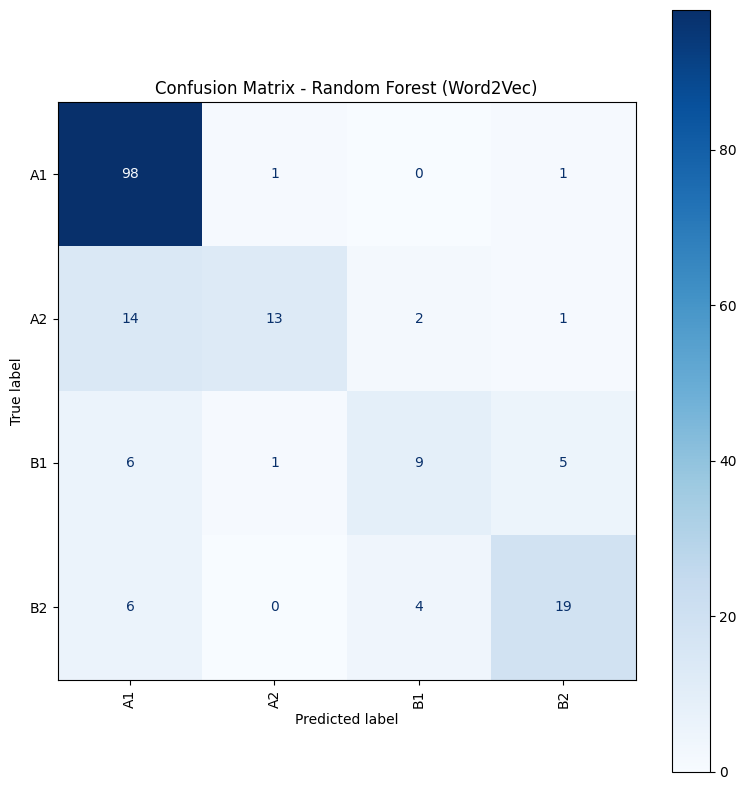

In [10]:
print("--- Đang huấn luyện Random Forest với Word2Vec ---")
model_rf_w2v = RandomForestClassifier(
    n_estimators=200,  # Số lượng cây, tương tự XGBoost
    random_state=42,
    n_jobs=-1,       
)

print("Đang huấn luyện Random Forest (Word2Vec)...")
start_time = time.time()
model_rf_w2v.fit(X_train_w2v, y_train_encoded, sample_weight=sample_weights)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá Random Forest (Word2Vec) trên tập Validation:")
y_pred_val_rf_w2v = model_rf_w2v.predict(X_val_w2v)
print(classification_report(y_val_encoded, y_pred_val_rf_w2v, target_names=class_names))

print("\nĐang vẽ Confusion Matrix cho Random Forest (Word2Vec)...")

# 1. Tính toán ma trận
cm_rf_w2v = confusion_matrix(y_val_encoded, y_pred_val_rf_w2v, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp_rf_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_rf_w2v, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp_rf_w2v.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest (Word2Vec)")
plt.tight_layout()
plt.show()


--- Đang huấn luyện Random Forest với TF-IDF ---
Đang huấn luyện Random Forest (TF-IDF)...
Huấn luyện hoàn tất sau 0.51 giây.

Đánh giá Random Forest (TF-IDF) trên tập Validation:
              precision    recall  f1-score   support

          A1       0.85      1.00      0.92       100
          A2       0.71      0.40      0.51        30
          B1       0.43      0.14      0.21        21
          B2       0.62      0.83      0.71        29

    accuracy                           0.77       180
   macro avg       0.65      0.59      0.59       180
weighted avg       0.74      0.77      0.74       180


Đang vẽ Confusion Matrix cho Random Forest (TF-IDF)...


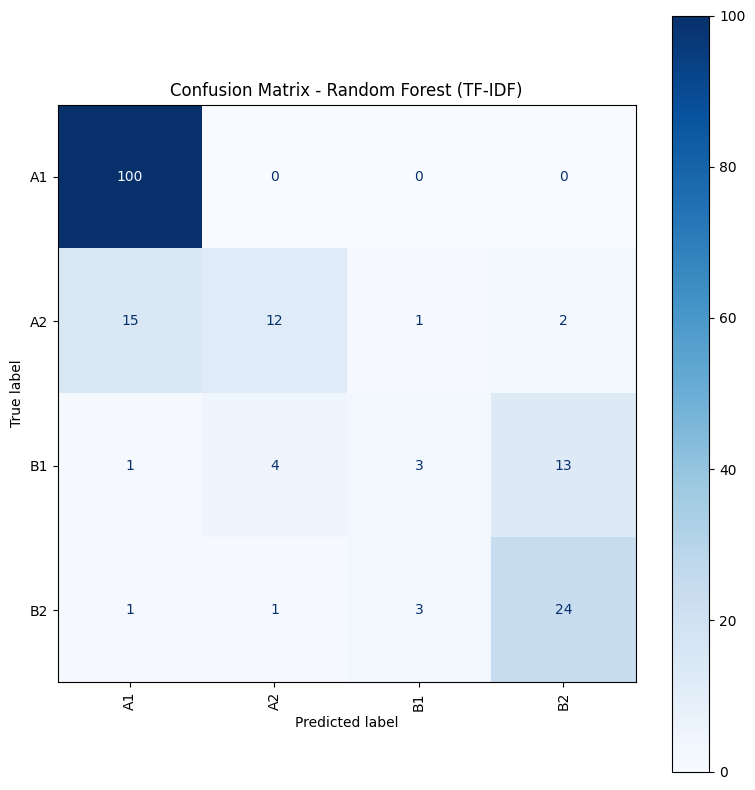

In [11]:
print("\n--- Đang huấn luyện Random Forest với TF-IDF ---")
model_rf_tfidf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

print("Đang huấn luyện Random Forest (TF-IDF)...")
start_time = time.time()
model_rf_tfidf.fit(X_train_tfidf, y_train_encoded,sample_weight=sample_weights)
end_time = time.time()
print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

print("\nĐánh giá Random Forest (TF-IDF) trên tập Validation:")
y_pred_val_rf_tfidf = model_rf_tfidf.predict(X_val_tfidf)
print(classification_report(y_val_encoded, y_pred_val_rf_tfidf, target_names=class_names))

print("\nĐang vẽ Confusion Matrix cho Random Forest (TF-IDF)...")

# 1. Tính toán ma trận
cm_rf_tfidf = confusion_matrix(y_val_encoded, y_pred_val_rf_tfidf, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp_rf_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tfidf, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp_rf_tfidf.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix - Random Forest (TF-IDF)")
plt.tight_layout()
plt.show()

## BƯỚC 7: TINH CHỈNH SIÊU THAM SỐ (HYPERPARAMETER TUNING)

Dựa trên các kết quả trên, mô hình `XGBoost + TF-IDF` cho kết quả tốt nhất. Chúng ta sẽ tinh chỉnh siêu tham số cho mô hình này.

**Lưu ý:** Quá trình này sẽ mất rất nhiều thời gian (có thể từ 10-30 phút hoặc hơn tùy vào cấu hình máy và `param_grid`).

#### 7.1. Gộp dữ liệu Train và Validation

In [12]:
# Gộp dữ liệu Train và Validation để GridSearchCV có thể tự thực hiện Cross-Validation trên toàn bộ dữ liệu.
print("Gộp dữ liệu Train và Validation (Word2Vec) để tinh chỉnh...")
X_train_val_w2v = np.vstack([X_train_w2v, X_val_w2v]) 
y_train_val_encoded = np.concatenate([y_train_encoded, y_val_encoded])
print(f"Kích thước dữ liệu gộp: {X_train_val_w2v.shape}")

# Tính trọng số cho dữ liệu GỘP (dùng cho GridSearchCV)
print("Đang tính toán trọng số cho dữ liệu gộp...")
sample_weights_gop = compute_sample_weight(
    class_weight='balanced',
    y=y_train_val_encoded
)
print("Tính toán trọng số gộp hoàn tất.")

Gộp dữ liệu Train và Validation (Word2Vec) để tinh chỉnh...
Kích thước dữ liệu gộp: (1440, 300)
Đang tính toán trọng số cho dữ liệu gộp...
Tính toán trọng số gộp hoàn tất.


#### 7.2. Thiết lập GridSearchCV

In [13]:
# Định nghĩa lưới tham số (Param Grid) - các tham số bạn muốn thử.
param_grid = {
    'n_estimators': [150, 250],        # Số lượng cây
    'max_depth': [5, 8, 10],           # Thử cây sâu hơn (vì W2V chỉ có 300 features)
    'learning_rate': [0.1, 0.2],     # Tốc độ học
    'subsample': [0.8, 1.0]            # Tỷ lệ mẫu dùng cho mỗi cây
}

# Khởi tạo mô hình XGBoost Gốc để tinh chỉnh
base_xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    random_state=42,
    n_jobs=-1
)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=base_xgb_model,
    param_grid=param_grid,
    cv=3, # 3-fold cross-validation
    scoring='accuracy',
    verbose=3, # In log chi tiết
    n_jobs=-1  # Sử dụng tất cả CPU
)

#### 7.3. Chạy Tinh chỉnh (Long-running task)

In [14]:
print("\nBắt đầu Grid Search... (Việc này sẽ mất RẤT LÂU)...")
start_time = time.time()
grid_search.fit(X_train_val_w2v, y_train_val_encoded,sample_weight=sample_weights_gop)
end_time = time.time()
print(f"\nGrid Search hoàn tất sau {end_time - start_time:.2f} giây.")


Bắt đầu Grid Search... (Việc này sẽ mất RẤT LÂU)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Grid Search hoàn tất sau 177.40 giây.


#### 7.4. Xem kết quả và lấy ra mô hình tốt nhất

In [ ]:
print("--- Kết quả Tinh chỉnh ---")
print(f"Accuracy tốt nhất tìm được (trên tập Val): {grid_search.best_score_ * 100:.2f}%")
print(f"Bộ tham số tốt nhất: {grid_search.best_params_}")

# Lấy ra mô hình TỐT NHẤT
best_tuned_model = grid_search.best_estimator_

# Lưu lại mô hình tốt nhất để sử dụng sau này
print("Lưu mô hình tốt nhất vào file 'best_tuned_model.pkl'...")
joblib.dump(best_tuned_model, 'best_tuned_model.pkl')
print("Lưu mô hình hoàn tất.")

--- Kết quả Tinh chỉnh ---
Accuracy tốt nhất tìm được (trên tập Val): 68.01%
Bộ tham số tốt nhất: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250, 'subsample': 1.0}
Lưu mô hình tốt nhất vào file 'best_tuned_model.pkl'...
Lưu mô hình hoàn tất.


## BƯỚC 8: ĐÁNH GIÁ CUỐI CÙNG TRÊN TẬP TEST

--- Đánh giá Cuối cùng trên TẬP TEST ---

Báo cáo Phân loại CUỐI CÙNG của mô hình tốt nhất (trên tập Test):
              precision    recall  f1-score   support

          A1       0.88      0.90      0.89       202
          A2       0.56      0.51      0.53        61
          B1       0.47      0.41      0.44        41
          B2       0.68      0.74      0.71        57

    accuracy                           0.75       361
   macro avg       0.65      0.64      0.64       361
weighted avg       0.75      0.75      0.75       361


Đang vẽ Confusion Matrix CUỐI CÙNG (trên tập Test)...


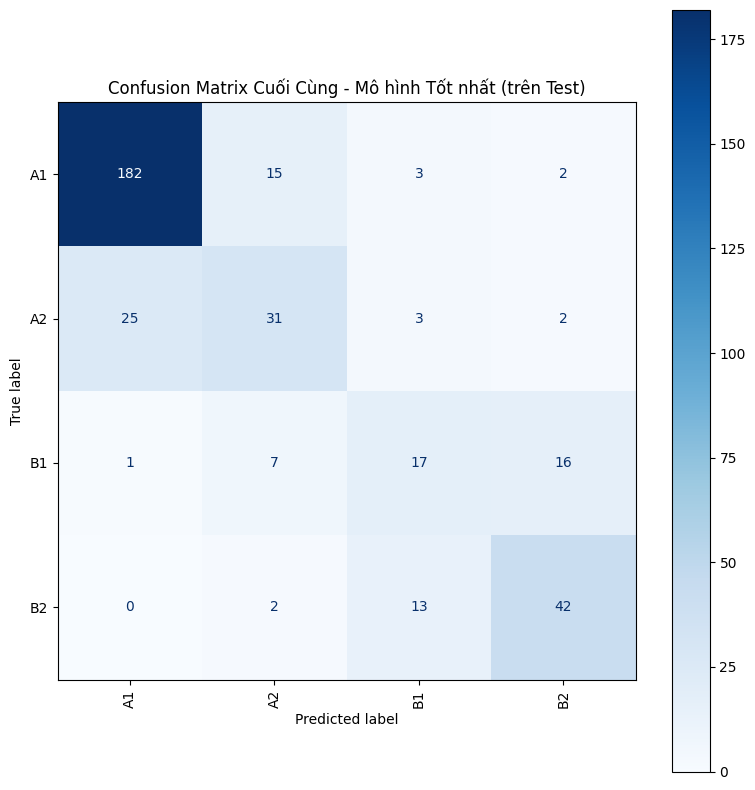

In [16]:
print("--- Đánh giá Cuối cùng trên TẬP TEST ---")

# Dùng mô hình đã được tinh chỉnh để dự đoán trên tập Test
y_pred_test_final = best_tuned_model.predict(X_test_w2v)

print("\nBáo cáo Phân loại CUỐI CÙNG của mô hình tốt nhất (trên tập Test):")
print(classification_report(y_test_encoded, y_pred_test_final, target_names=class_names))

print("\nĐang vẽ Confusion Matrix CUỐI CÙNG (trên tập Test)...")

# 1. Tính toán ma trận
cm_final = confusion_matrix(y_test_encoded, y_pred_test_final, labels=le.transform(class_names))

# 2. Hiển thị ma trận
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8)) # Tùy chỉnh kích thước nếu cần
disp_final.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix Cuối Cùng - Mô hình Tốt nhất (trên Test)")
plt.tight_layout()
plt.show()

## BƯỚC 9: GIẢI THÍCH MÔ HÌNH VỚI SHAP

Chúng ta sẽ sử dụng mô hình tốt nhất vừa tìm được (`best_tuned_model`) để xem tại sao nó lại đưa ra các dự đoán như vậy.

**Lưu ý:** `KernelExplainer` có thể chạy khá chậm.

#### 9.1. Chuẩn bị SHAP

In [17]:
# 9.1: Chuẩn bị SHAP
print("--- Chuẩn bị cho SHAP ---")

# 1. Đảm bảo các biến cần thiết có trong bộ nhớ
if 'model_xgb_w2v' not in locals():
    print("LỖI: Biến 'model_xgb_w2v' không tồn tại. Vui lòng chạy lại.")
    raise NameError("Chưa chạy lại")

if 'X_train_w2v' not in locals():
    print("LỖI: Biến 'X_train_w2v' không tồn tại. Vui lòng chạy lại.")
    raise NameError("Chưa chạy lại")

if 'X_test_w2v' not in locals():
    print("LỖI: Biến 'X_test_w2v' không tồn tại. Vui lòng chạy lại.")
    raise NameError("Chưa chạy lại")
    
if 'feature_names' not in locals():
    print("LỖI: Biến 'feature_names' không tồn tại. Vui lòng chạy lại.")
    with open('dataframes/tfidf_vectorizer.pkl', 'rb') as f:
         tfidf_vectorizer = pickle.load(f)
    feature_names = tfidf_vectorizer.get_feature_names_out()

# 2. Khởi tạo Javascript của SHAP
shap.initjs()
print("Chuẩn bị SHAP hoàn tất.")

--- Chuẩn bị cho SHAP ---
LỖI: Biến 'feature_names' không tồn tại. Vui lòng chạy lại.


Chuẩn bị SHAP hoàn tất.


#### 9.2. Tạo SHAP Explainer

In [18]:
# 9.2: Tạo SHAP Explainer
print("--- Tạo SHAP Explainer ---")

# Dùng `shap.sample` để lấy 100 mẫu nền (thay vì toàn bộ 1260 dòng)
print("Lấy 100 mẫu nền (background sample) từ X_train_w2v...")
background_sample = shap.sample(X_train_w2v, 100) 

# Khởi tạo TreeExplainer
print("Đang tạo SHAP TreeExplainer...")
explainer = shap.TreeExplainer(
    model_xgb_w2v, 
    background_sample
)
print("Tạo TreeExplainer hoàn tất.")

--- Tạo SHAP Explainer ---
Lấy 100 mẫu nền (background sample) từ X_train_w2v...
Đang tạo SHAP TreeExplainer...
Tạo TreeExplainer hoàn tất.


#### 9.3: Chuẩn bị dữ liệu và Tính toán SHAP Values


In [19]:
# 9.3: Tính toán SHAP Values
print("--- Chuẩn bị dữ liệu và Tính toán SHAP Values ---")

# --- 1. Tải các dữ liệu cần thiết từ tập Test ---
print("Đang tải dữ liệu test (văn bản và nhãn)...")
df_test = pd.read_csv('dataframes/test_data.csv')
y_test = pd.read_csv('dataframes/y_test.csv')['label']
y_test_encoded = le.transform(y_test)

# --- 2. Lấy 50 mẫu đầu tiên từ tập Test để giải thích ---
SAMPLES_TO_EXPLAIN = 50

print(f"Lấy {SAMPLES_TO_EXPLAIN} mẫu đầu tiên từ tập test (Word2Vec)...")
samples_to_explain_dense = X_test_w2v[0:SAMPLES_TO_EXPLAIN] # Đã là dense

# Lấy văn bản, nhãn, và dự đoán tương ứng
test_texts_sample = df_test['text'].iloc[0:SAMPLES_TO_EXPLAIN].values
y_test_sample = y_test_encoded[0:SAMPLES_TO_EXPLAIN]
y_pred_sample = model_xgb_w2v.predict(samples_to_explain_dense) # Lấy dự đoán

# --- 3. Tính toán SHAP ---
print(f"Đang tính toán giá trị SHAP cho {SAMPLES_TO_EXPLAIN} mẫu...")
shap_explanation = explainer(samples_to_explain_dense)
print("Tính toán SHAP hoàn tất.")

--- Chuẩn bị dữ liệu và Tính toán SHAP Values ---
Đang tải dữ liệu test (văn bản và nhãn)...
Lấy 50 mẫu đầu tiên từ tập test (Word2Vec)...
Đang tính toán giá trị SHAP cho 50 mẫu...
Tính toán SHAP hoàn tất.


#### 9.4: Tổng quan (Bar Plot)


--- Phân tích Tổng quan (Bar Plot) ---
Biểu đồ này cho thấy các 'feature' (chiều vector) quan trọng nhất.


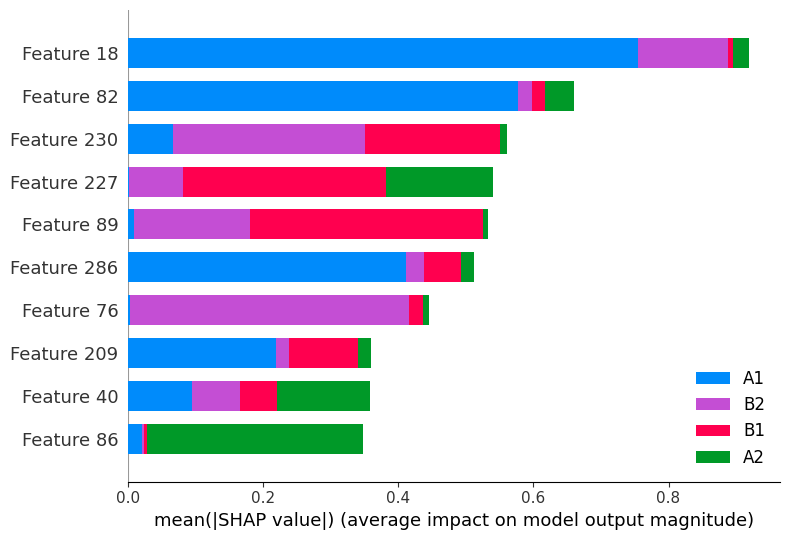

In [20]:
# 9.4: Phân tích Tổng quan (Bar Plot)
print("--- Phân tích Tổng quan (Bar Plot) ---")
print("Biểu đồ này cho thấy các 'feature' (chiều vector) quan trọng nhất.")
# Tên feature bây giờ sẽ là 0, 1, 2... 299 (vì Word2Vec là ẩn danh)

shap.summary_plot(
    shap_explanation.values,
    samples_to_explain_dense,
    class_names=class_names,
    plot_type="bar",
    max_display=10 
)

### 9.5: Phân tích Chuyên sâu (Beeswarm Plot - Lớp B1)

--- Phân tích Chuyên sâu: Lớp B1 (index 2) ---
Đang vẽ Beeswarm Plot cho lớp 'B1'


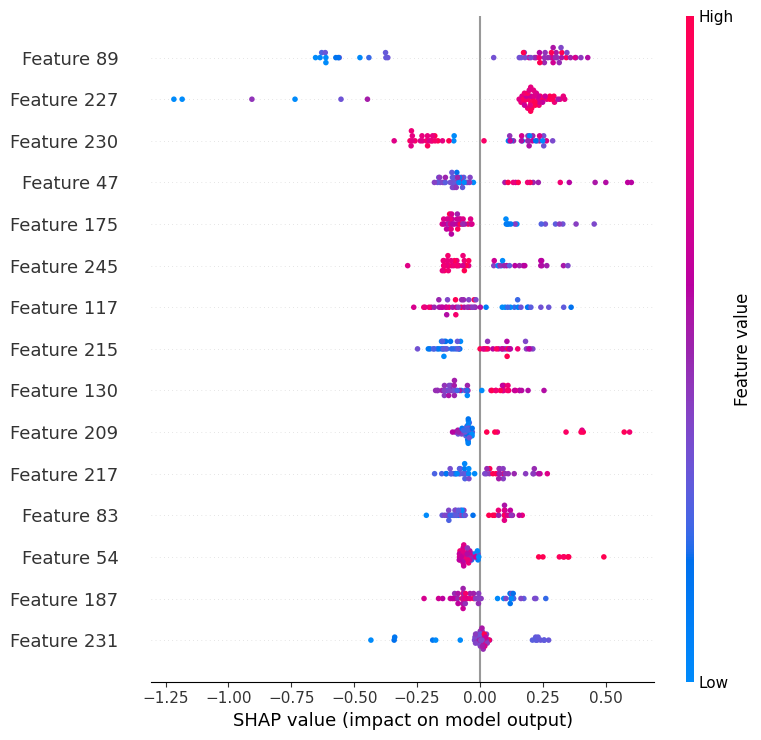

In [21]:
# 9.5: Phân tích Chuyên sâu: Lớp B1 (index 2)
print("--- Phân tích Chuyên sâu: Lớp B1 (index 2) ---")
class_index = 2 # 0: A1, 1: A2, 2: B1, 3: B2
print(f"Đang vẽ Beeswarm Plot cho lớp '{class_names[class_index]}'")

shap.summary_plot(
    shap_explanation.values[:, :, class_index], 
    samples_to_explain_dense, 
    max_display=15 
)

### Case Study 1 - Tại sao mô hình dự đoán SAI (False Negative)


--- Case Study 1: Mẫu B1 bị dự đoán SAI (False Negative) ---
Đang phân tích mẫu index 34 (trong 50 mẫu)...
Văn bản gốc: ...  to the discovery of the bodies of a missing ohio woman her year old son and a family friend authorities said thursday the remains of tina herrmann her year old son kody maynard and her year old frien ...
Dự đoán là: B2
Thực tế là: B1

Lý do dự đoán SAI (phân tích lớp B2):


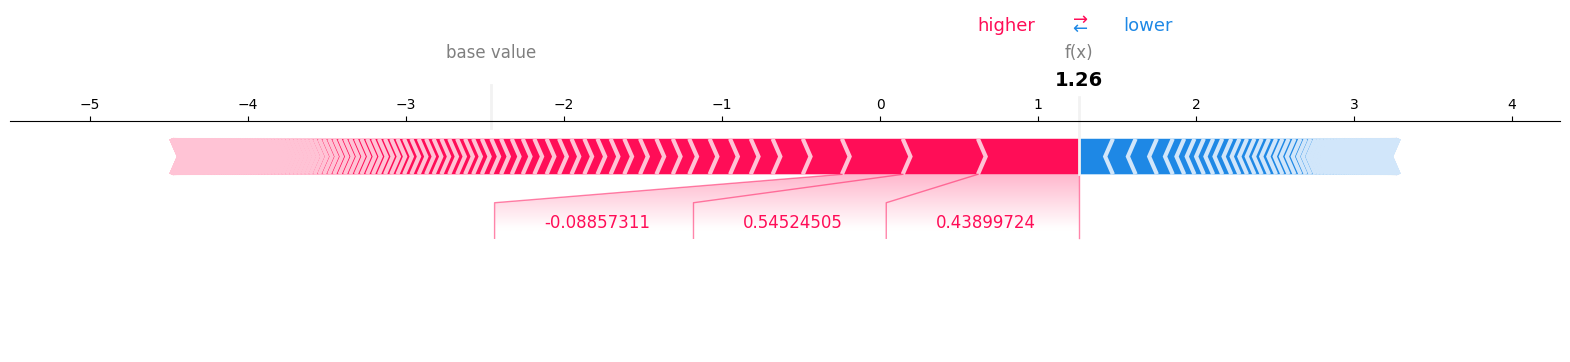

In [22]:
# Case Study 1: Mẫu B1 bị dự đoán SAI (False Negative)
print("--- Case Study 1: Mẫu B1 bị dự đoán SAI (False Negative) ---")

actual_b1 = (y_test_sample == 2)
predicted_not_b1 = (y_pred_sample != 2)
misclassified_indices = np.where(actual_b1 & predicted_not_b1)[0]

if len(misclassified_indices) > 0:
    idx = misclassified_indices[0] 
    wrong_class_index = y_pred_sample[idx]

    print(f"Đang phân tích mẫu index {idx} (trong {SAMPLES_TO_EXPLAIN} mẫu)...")
    print(f"Văn bản gốc: ... {test_texts_sample[idx][50:250]} ...") 
    print(f"Dự đoán là: {class_names[wrong_class_index]}")
    print(f"Thực tế là: {class_names[y_test_sample[idx]]}")

    print(f"\nLý do dự đoán SAI (phân tích lớp {class_names[wrong_class_index]}):")
    shap.force_plot(
        shap_explanation.base_values[idx, wrong_class_index],
        shap_explanation.values[idx, :, wrong_class_index],
        samples_to_explain_dense[idx],
        matplotlib=True
    )
else:
    print(f"Tuyệt vời! Không tìm thấy mẫu B1 nào bị dự đoán sai trong {SAMPLES_TO_EXPLAIN} mẫu đầu tiên.")

### Case Study 2 - Tại sao mô hình dự đoán ĐÚNG (True Positive)

--- Case Study 2: Mẫu B1 được dự đoán ĐÚNG (True Positive) ---
Đang phân tích mẫu index 14 (trong 50 mẫu)...
Văn bản gốc: ... orhood of los angeles the march was sponsored by a coalition of local organizations and agencies the purpose of the march was to bring awareness to the violence in the community many people have been  ...
Dự đoán là: B1
Thực tế là: B1

Lý do dự đoán ĐÚNG (phân tích lớp B1):


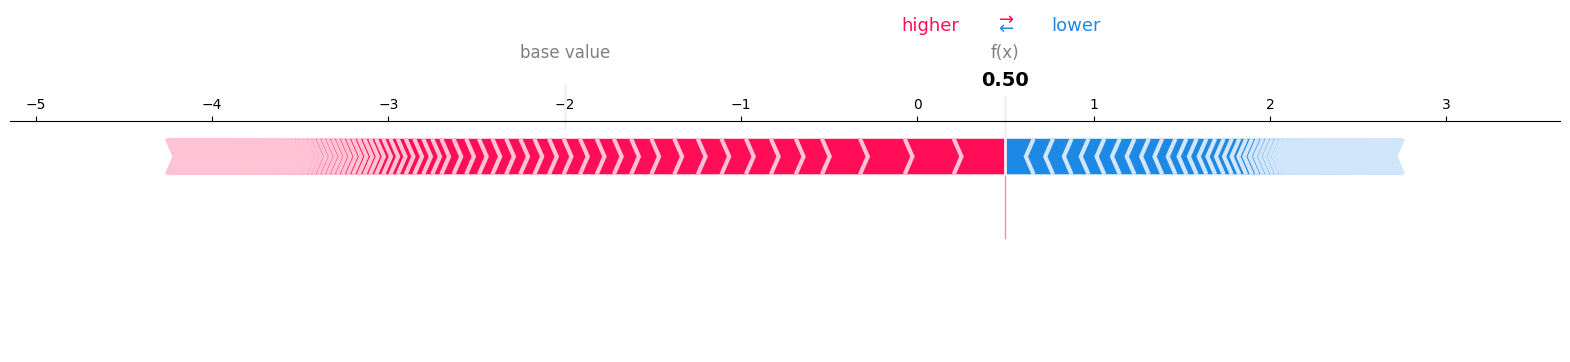

In [23]:
# Case Study 2: Mẫu B1 được dự đoán ĐÚNG (True Positive)
print("--- Case Study 2: Mẫu B1 được dự đoán ĐÚNG (True Positive) ---")

actual_b1 = (y_test_sample == 2)
predicted_b1 = (y_pred_sample == 2)
correct_indices = np.where(actual_b1 & predicted_b1)[0]

if len(correct_indices) > 0:
    idx = correct_indices[0] 
    class_index = 2

    print(f"Đang phân tích mẫu index {idx} (trong {SAMPLES_TO_EXPLAIN} mẫu)...")
    print(f"Văn bản gốc: ... {test_texts_sample[idx][50:250]} ...") 
    print(f"Dự đoán là: {class_names[y_pred_sample[idx]]}")
    print(f"Thực tế là: {class_names[y_test_sample[idx]]}")

    print(f"\nLý do dự đoán ĐÚNG (phân tích lớp {class_names[class_index]}):")
    shap.force_plot(
        shap_explanation.base_values[idx, class_index],
        shap_explanation.values[idx, :, class_index],
        samples_to_explain_dense[idx],
        matplotlib=True
    )
else:
    print(f"Không tìm thấy mẫu B1 nào được dự đoán đúng trong {SAMPLES_TO_EXPLAIN} mẫu đầu tiên.")